In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scanpy as sc
import anndata
import umap.umap_ as umap
import leidenalg
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
from sklearn.cluster import KMeans
from scipy.spatial.distance import pdist, squareform
from sklearn.metrics import pairwise_distances
from scipy.stats import zscore
from matplotlib.colorbar import ColorbarBase
import matplotlib.colors as mcolors

%matplotlib inline

In [2]:
plt.style.use('dark_background')

### Tools

#### Generating umap

In [26]:
def generate_umap(cosmx_scdata, sample_id = '', color = 'leiden', color_map = 'coolwarm'):
    #sc.pp.normalize_total(cosmx_scdata)
    #sc.pp.scale(cosmx_scdata, zero_center = True)
    #sc.pp.pca(cosmx_scdata, n_comps = 50, random_state = 42)
    #umap_operator = umap.UMAP(n_components = 2, random_state = 42, metric = 'euclidean', min_dist = 0.01)
    #umap_result_cosmx = umap_operator.fit_transform(cosmx_scdata.obsm['X_scaled_pca'])
    #cosmx_scdata.obsm['X_umap'] = umap_result_cosmx
    #sc.pp.neighbors(cosmx_scdata, use_rep = 'X_umap', n_neighbors = 40)
    #sc.tl.leiden(cosmx_scdata, resolution = res)
    sc.set_figure_params(figsize=(10,10))
    fig = sc.pl.umap(
        cosmx_scdata,
        color=color,
        color_map = color_map,
        add_outline=True,
        legend_loc="on data",
        size=1,
        legend_fontsize=12,
        legend_fontoutline=1,
        frameon=False,
        title=f"MERFISH clustering of {len(cosmx_scdata):,d} cells for CosMx {sample_id} mouse",
        vmax = 10
    )

#### Cell type heatmap

In [21]:
def generate_cell_type(scdata, ref_df):
    sc.tl.rank_genes_groups(scdata, groupby = 'leiden', method = 'wilcoxon', use_raw = False)
    
    gene_expression_df = pd.DataFrame()
    for cluster in scdata.obs['leiden'].cat.categories:
        cluster_gene_name = scdata.uns['rank_genes_groups']['names'][cluster]
        cluster_gene_score = scdata.uns['rank_genes_groups']['scores'][cluster]
        gene_expression_df[cluster] = {key: val for key, val in zip(cluster_gene_name, cluster_gene_score)}

    gene_expression_df.index = gene_expression_df.index.map(str.capitalize)
    gene_expression_df = gene_expression_df.T
    
    genes_list = gene_expression_df.columns.tolist()
    
    #comparison_df = ref_df[ref_df['feature'].isin(genes_list)].reset_index().drop(columns = ['index']).set_index('feature')
    comparison_df = ref_df[ref_df['feature'].isin(genes_list)].reset_index().drop(columns = ['index']).set_index('feature').T
    comparison_df = comparison_df.groupby(comparison_df.index).mean().T
    
    gene_expression_df_postprocessed = gene_expression_df.loc[:, gene_expression_df.columns.isin(comparison_df.index)]
    
    update_list_genes = np.array(gene_expression_df_postprocessed.columns)
    
    scdata_subset = scdata[:, scdata.var_names.isin(np.vectorize(str.upper)(update_list_genes))].copy()
    
    #scdata_subset.X_expand = scdata_subset.X.toarray()
    
    X_MERFISH_zscored = zscore(scdata_subset.X, axis=0)
    clusters = scdata_subset.obs['leiden']
    uclusters = np.unique(clusters)
    X_MERFISH_zscored_per_cluster = np.array([np.mean(X_MERFISH_zscored[cl==clusters],axis=0) for cl in uclusters])

    #X_seq = np.array(comparison_df.iloc[:,1:]).T
    X_seq = np.array(comparison_df.iloc[:,0:]).T
    X_seq[np.isnan(X_seq)]=0
    X_seq_zscored = zscore(X_seq,axis=0)
    X_seq_zscored[np.isnan(X_seq_zscored)]=0
    
    Mcor = [[np.corrcoef(clMER,clSEQ)[0,1] for clSEQ in X_seq_zscored] for clMER in X_MERFISH_zscored_per_cluster]
    
    #names_seq = list(comparison_df.keys())[1:]
    names_seq = list(comparison_df.keys())[0:]
    
    Mcor_t = np.array(Mcor).T
    
    plt.style.use('dark_background')
    plt.figure(figsize=(15,25))
    #plt.imshow(xenium_Mcor,cmap='bwr')
    plt.imshow(Mcor_t,cmap='bwr')
    plt.yticks(np.arange(len(names_seq)),names_seq,rotation=35,ha='right');
    #plt.yticks(np.arange(len(uclusters)),[(ucl,dic_rename[ucl])for ucl in uclusters]);
    plt.xticks(np.arange(len(uclusters)),uclusters)
    plt.xlabel('Cell Clusters from our MERFISH in mouse cortex', size=30)
    plt.ylabel('Cell Clusters from sn-RNASeq in mouse cortex \n(Allan Brian Atlas)', size=30);
    plt.tick_params(axis='x', top=True)
    plt.gca().xaxis.set_ticks_position('top')
    plt.gca().xaxis.set_label_position('top')
    

#### Cell type labeling

In [4]:
def label_cell_type(scdata, cell_type_dictionary):
    # Convert category keys in the dictionary to strings
    xenium_cluster_name_mapping = {str(k): v for k, v in cell_type_dictionary.items()}

    # Map cluster IDs to cluster names using the updated dictionary
    scdata.obs['cluster_names'] = scdata.obs['leiden'].astype(str).map(xenium_cluster_name_mapping)

### Load CosMx data

In [5]:
cosmx_scdata = sc.read_h5ad(r"D:\SMI-0214_DonCleveland_UCSD\SMI-0214_DonCleveland_UCSD\SMI_0214.h5ad")
cosmx_scdata

AnnData object with n_obs × n_vars = 133212 × 960
    obs: 'Area', 'AspectRatio', 'Beta', 'Blank', 'CD45', 'Celltype_long', 'DAPI', 'Height', 'Histone', 'ISH.concentration', 'Louvain clustering (resolution=3.0)', 'Louvain clustering (resolution=3.0) (1)', 'Louvain sub-clustering (resolution=1.0)', 'Louvain sub-clustering (resolution=1.0) (1)', 'Major_cell_type', 'Max.Blank', 'Max.DAPI', 'Max.GFAP', 'Max.Histone', 'Max.rRNA', 'Mean.Blank', 'Mean.DAPI', 'Mean.GFAP', 'Mean.Histone', 'Mean.rRNA', 'Number of genes', 'Number of mRNA transcripts', 'Percentage of negative controls', 'Run_Slide_name', 'Run_Tissue_name', 'Run_name', 'Slide_name', 'Width', 'fov', 'identification', 'leiden_clus', 'log10totalcounts', 'nCount_Nanostring', 'nFeature_Nanostring', 'nb_clus', 'orig.ident', 'rRNA', 'seurat_clusters_hvg950', 'slide_ID_numeric', 'test cell type', 'tissue'
    obsm: 'X_pca', 'X_pca_(no_batch_corrected)', 'X_scaled_pca', 'X_tsne', 'X_tsne_(perplexity=30)', 'X_tsne_(perplexity=30)_-_scaled_pc

### Load allen brain atlas dataset

In [14]:
fl = r"D:\SMI-0214_DonCleveland_UCSD\SMI-0214_DonCleveland_UCSD\allen_brain_atlas_trimmed_means.csv"
aba = pd.read_csv(fl)
#aba

In [15]:
aba_column_list = list(aba.columns)
#aba_column_list

In [16]:
aba_column_list_revised = ['feature']
for i in range(1,len(aba_column_list)):
    aba_column_list_revised.append(aba_column_list[i].split('_')[1])
#aba_column_list_revised

In [18]:
aba.columns = aba_column_list_revised
#aba

### Generate Cosmx UMAP

C:\Users\krist\AppData\Local\Programs\Python\Python311\Lib\site-packages\umap\umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
C:\Users\krist\AppData\Local\Programs\Python\Python311\Lib\site-packages\scanpy\plotting\_tools\scatterplots.py:371: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(
C:\Users\krist\AppData\Local\Programs\Python\Python311\Lib\site-packages\scanpy\plotting\_tools\scatterplots.py:381: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(
C:\Users\krist\AppData\Local\Programs\Python\Python311\Lib\site-packages\scanpy\plotting\_tools\scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


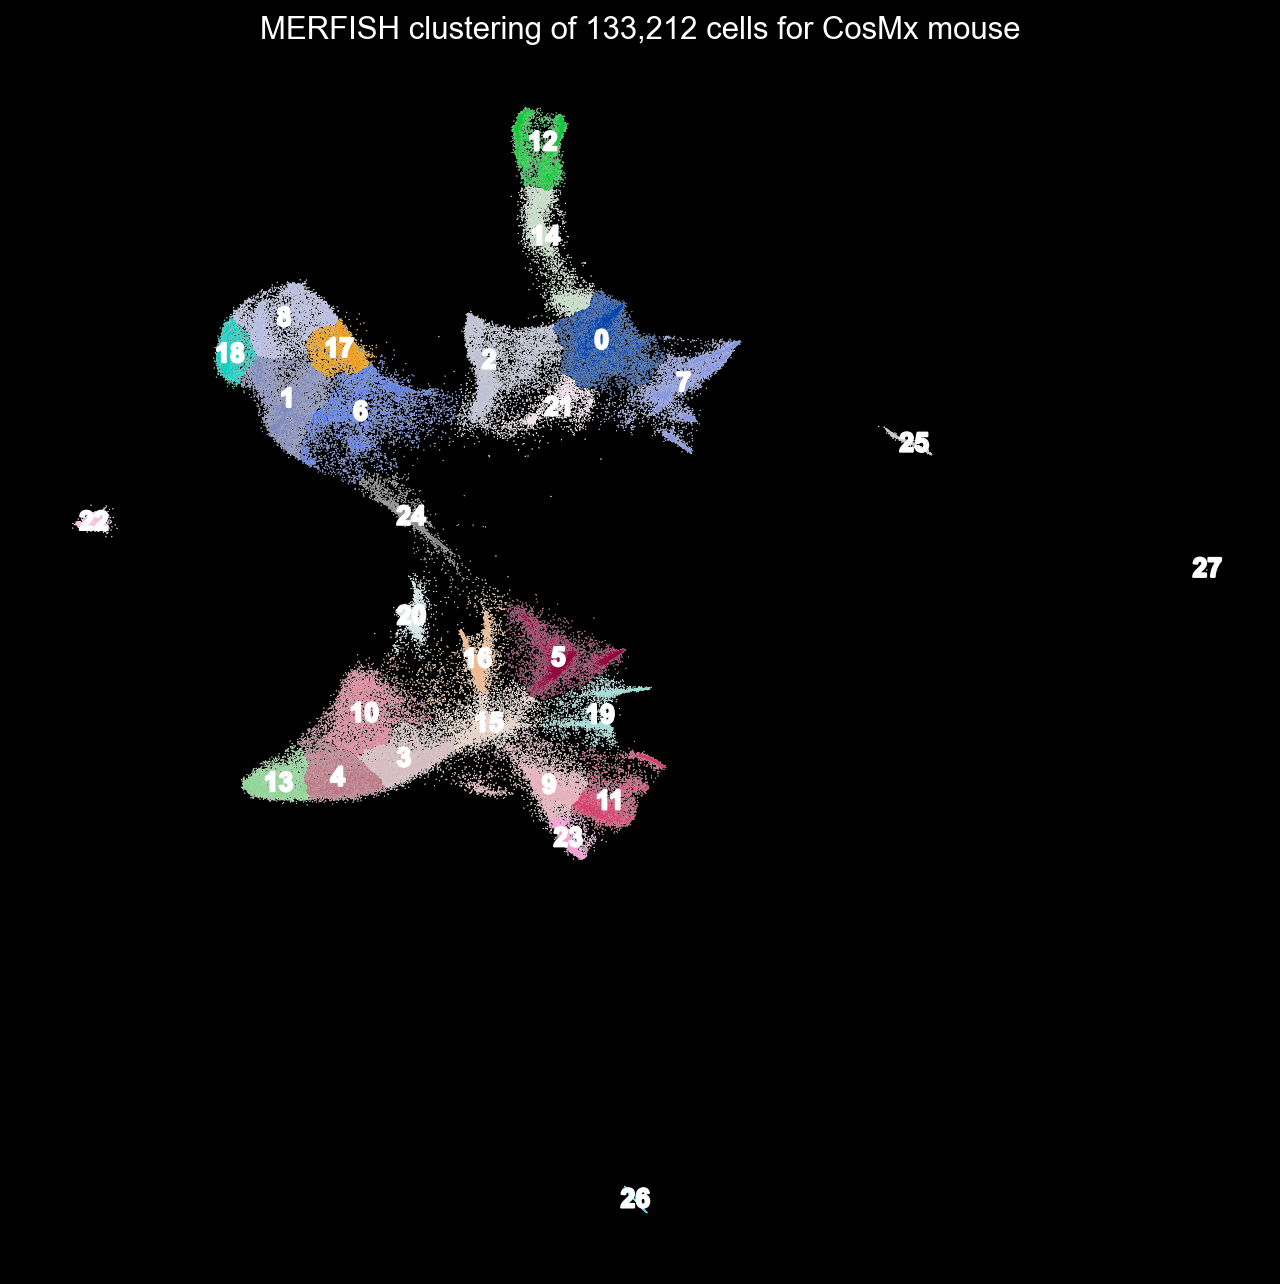

In [6]:
sc.pp.normalize_total(cosmx_scdata)
sc.pp.scale(cosmx_scdata, zero_center = True)
sc.pp.pca(cosmx_scdata, n_comps = 50, random_state = 42)
umap_operator = umap.UMAP(n_components = 2, random_state = 42, metric = 'euclidean', min_dist = 0.01)
umap_result_cosmx = umap_operator.fit_transform(cosmx_scdata.obsm['X_scaled_pca'])
cosmx_scdata.obsm['X_umap'] = umap_result_cosmx
sc.pp.neighbors(cosmx_scdata, use_rep = 'X_umap', n_neighbors = 40)
sc.tl.leiden(cosmx_scdata, resolution = 0.125)
sc.set_figure_params(figsize=(10,10))
fig = sc.pl.umap(
    cosmx_scdata,
    color='leiden',
    color_map = 'coolwarm',
    add_outline=True,
    legend_loc="on data",
    size=1,
    legend_fontsize=12,
    legend_fontoutline=1,
    frameon=False,
    title=f"MERFISH clustering of {len(cosmx_scdata):,d} cells for CosMx mouse",
    vmax = 10
)

#### Remove artifact clusters and recluster with the remaining clusters

In [7]:
clusters_to_remove = ['22','25','26', '27']

In [8]:
cosmx_scdata.obs['leiden'] = cosmx_scdata.obs['leiden'].astype(str).str.strip()
revised_cosmx_scdata = cosmx_scdata[~cosmx_scdata.obs['leiden'].isin(clusters_to_remove)].copy()

In [9]:
sc.pp.normalize_total(revised_cosmx_scdata)
sc.pp.scale(revised_cosmx_scdata, zero_center = True)
sc.pp.pca(revised_cosmx_scdata, n_comps = 50, random_state = 42)
umap_operator = umap.UMAP(n_components = 2, random_state = 42, metric = 'euclidean', min_dist = 0.01)
umap_result_cosmx = umap_operator.fit_transform(revised_cosmx_scdata.obsm['X_scaled_pca'])
revised_cosmx_scdata.obsm['X_umap'] = umap_result_cosmx
sc.pp.neighbors(revised_cosmx_scdata, use_rep = 'X_umap', n_neighbors = 40)
sc.tl.leiden(revised_cosmx_scdata, resolution = 0.125)
sc.set_figure_params(figsize=(10,10))

C:\Users\krist\AppData\Local\Programs\Python\Python311\Lib\site-packages\scanpy\preprocessing\_normalization.py:196: UserWarning: Some cells have zero counts
  warn(UserWarning('Some cells have zero counts'))
C:\Users\krist\AppData\Local\Programs\Python\Python311\Lib\site-packages\umap\umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


C:\Users\krist\AppData\Local\Programs\Python\Python311\Lib\site-packages\scanpy\plotting\_tools\scatterplots.py:371: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(
C:\Users\krist\AppData\Local\Programs\Python\Python311\Lib\site-packages\scanpy\plotting\_tools\scatterplots.py:381: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(
C:\Users\krist\AppData\Local\Programs\Python\Python311\Lib\site-packages\scanpy\plotting\_tools\scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


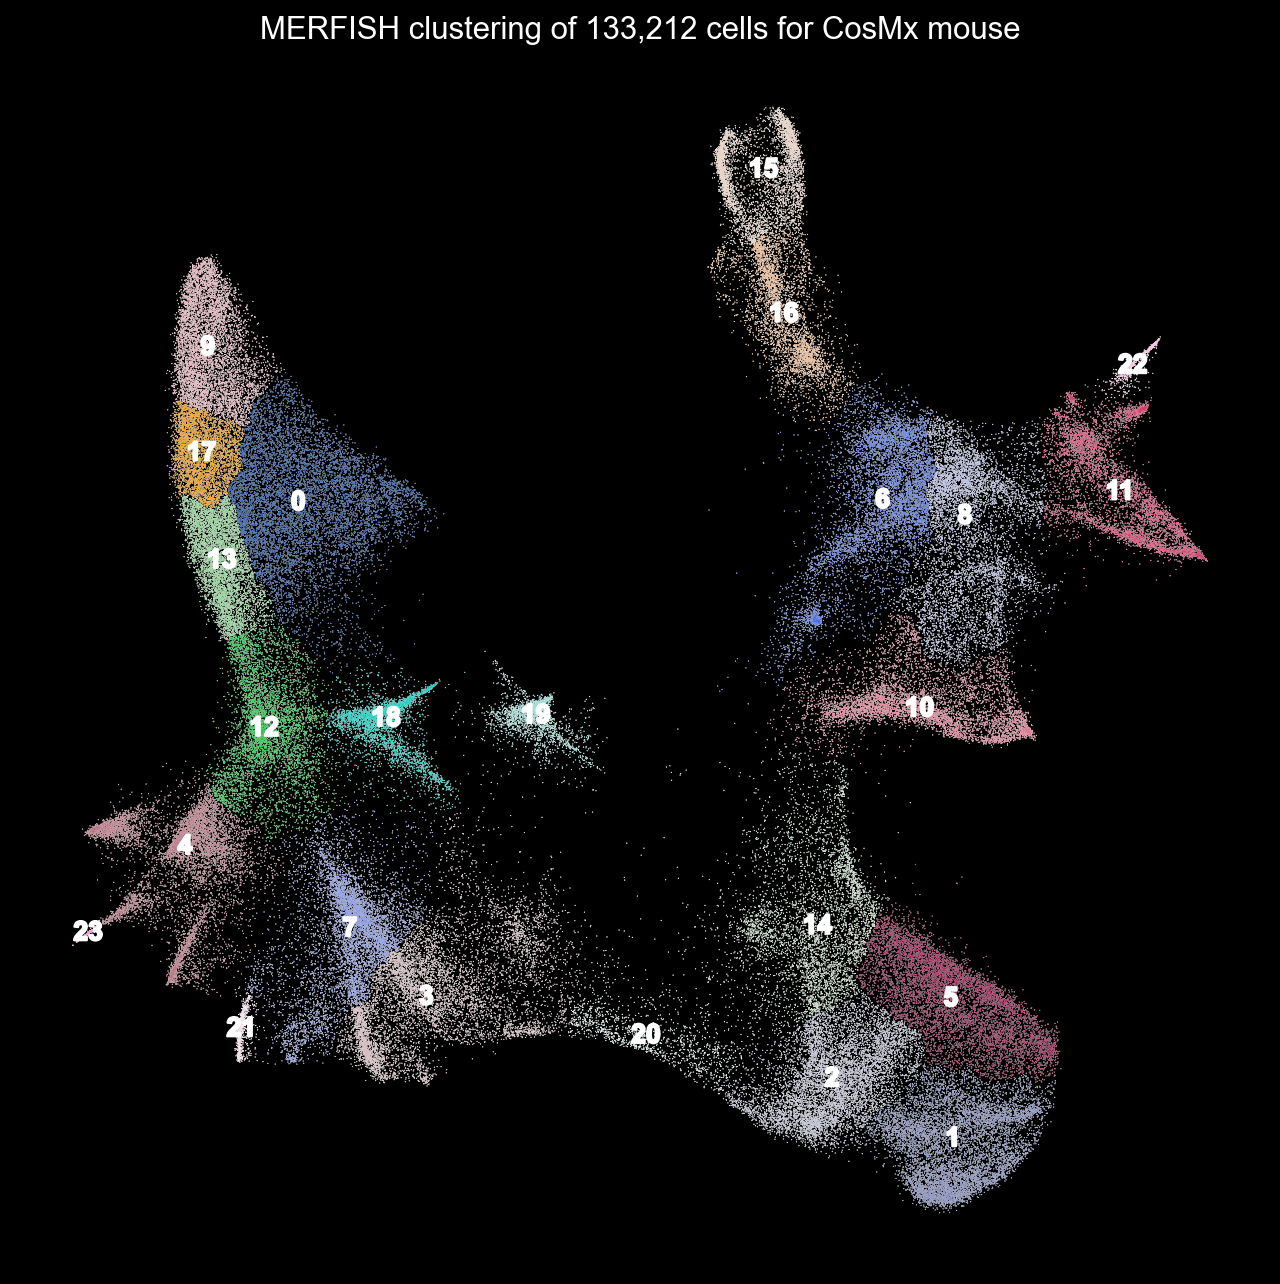

In [10]:
fig = sc.pl.umap(
    revised_cosmx_scdata,
    color='leiden',
    color_map = 'coolwarm',
    add_outline=True,
    legend_loc="on data",
    size=1,
    legend_fontsize=12,
    legend_fontoutline=1,
    frameon=False,
    title=f"MERFISH clustering of {len(cosmx_scdata):,d} cells for CosMx mouse",
    vmax = 10,
    #save = 'Cosmx leiden umap (res=0.125).png'
)

In [12]:
revised_cosmx_scdata

AnnData object with n_obs × n_vars = 128311 × 960
    obs: 'Area', 'AspectRatio', 'Beta', 'Blank', 'CD45', 'Celltype_long', 'DAPI', 'Height', 'Histone', 'ISH.concentration', 'Louvain clustering (resolution=3.0)', 'Louvain clustering (resolution=3.0) (1)', 'Louvain sub-clustering (resolution=1.0)', 'Louvain sub-clustering (resolution=1.0) (1)', 'Major_cell_type', 'Max.Blank', 'Max.DAPI', 'Max.GFAP', 'Max.Histone', 'Max.rRNA', 'Mean.Blank', 'Mean.DAPI', 'Mean.GFAP', 'Mean.Histone', 'Mean.rRNA', 'Number of genes', 'Number of mRNA transcripts', 'Percentage of negative controls', 'Run_Slide_name', 'Run_Tissue_name', 'Run_name', 'Slide_name', 'Width', 'fov', 'identification', 'leiden_clus', 'log10totalcounts', 'nCount_Nanostring', 'nFeature_Nanostring', 'nb_clus', 'orig.ident', 'rRNA', 'seurat_clusters_hvg950', 'slide_ID_numeric', 'test cell type', 'tissue', 'leiden'
    var: 'mean', 'std'
    uns: 'pca', 'neighbors', 'leiden', 'leiden_colors'
    obsm: 'X_pca', 'X_pca_(no_batch_corrected)',

In [11]:
revised_cosmx_scdata.write(r"D:\SMI-0214_DonCleveland_UCSD\SMI-0214_DonCleveland_UCSD\SMI_0214_revised.h5ad")

### Generate cell type heatmap

C:\Users\krist\AppData\Local\Programs\Python\Python311\Lib\site-packages\scanpy\tools\_rank_genes_groups.py:422: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
C:\Users\krist\AppData\Local\Programs\Python\Python311\Lib\site-packages\scanpy\tools\_rank_genes_groups.py:422: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
C:\Users\krist\AppData\Local\Programs\Python\Python311\Lib\site-packages\scanpy\tools\_rank_genes_groups.py:422: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
C:\Users\krist\AppData\Local\Programs\Python\Python311\Lib\site-packages\scanpy\tools\_rank_genes_groups.py:422: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
C:\Users\krist\AppData\Local\Programs\Python\Python311\Lib\site-packages\scanpy\tools\_rank_genes_groups.py:422: RuntimeWarning: inv

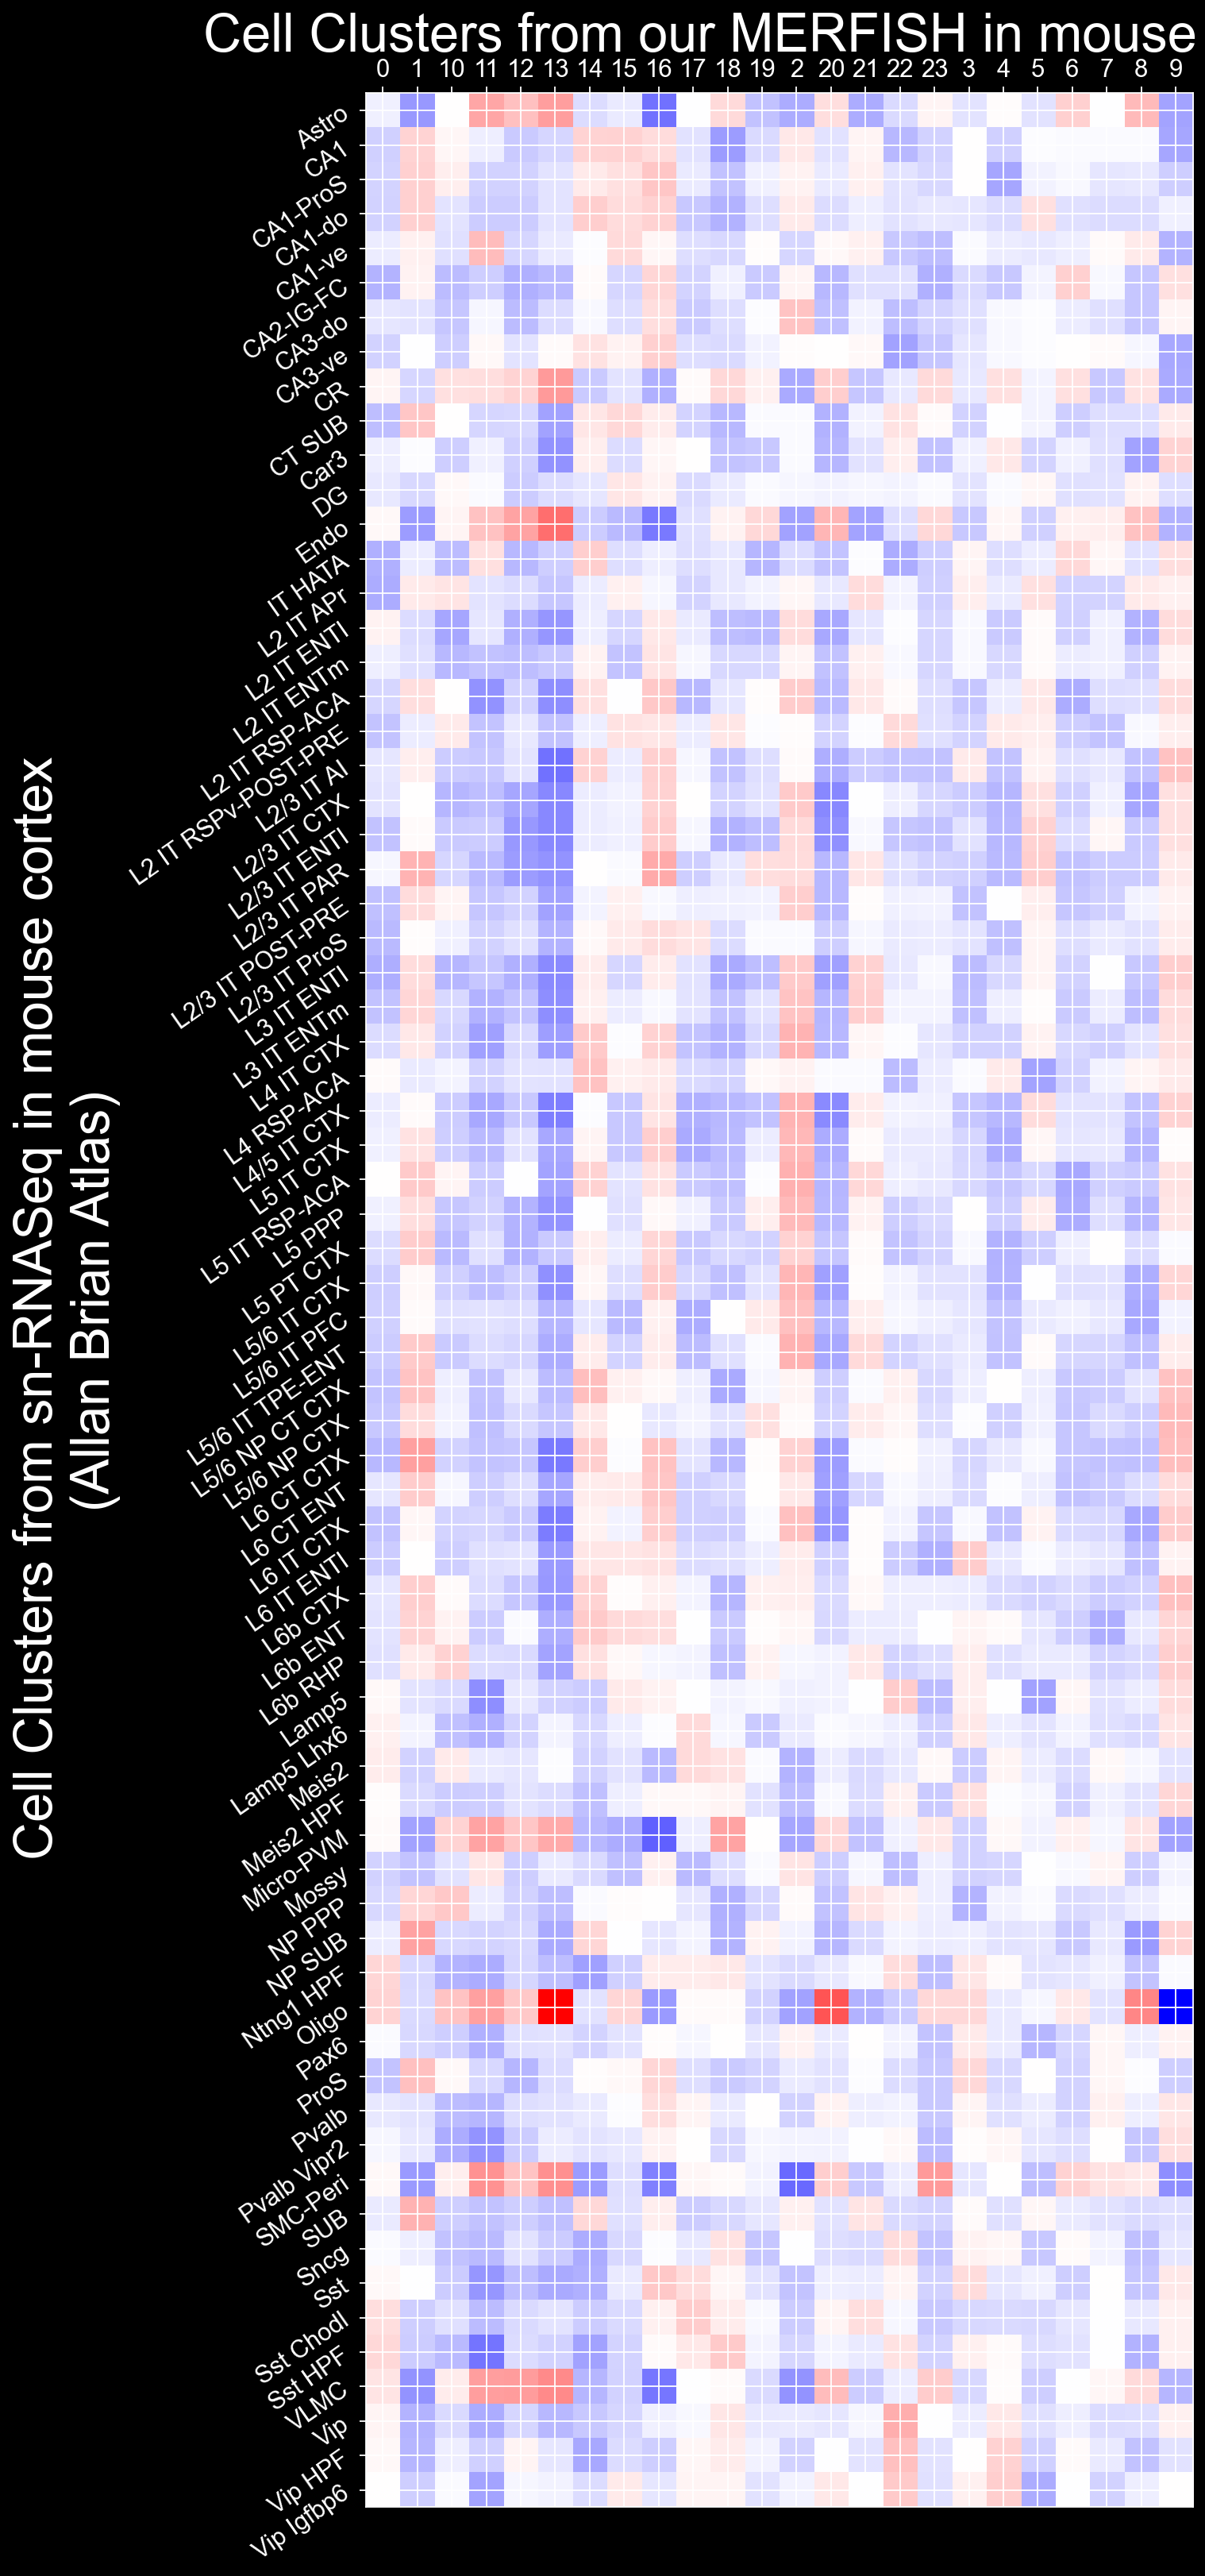

In [22]:
generate_cell_type(revised_cosmx_scdata, aba)

### Generate cell type labels

In [ ]:
cosmx_cluster_name_mapping = {
    '0': '',
    '1': '',
    '2': '',
    '3': '',
    '4': '',
    '5': '',
    '6': '',
    '7': '',
    '8': '',
    '9': '',
    '10': '',
    '11': '',
    '12': '',
    '13': '',
    '14': '',
    '15': '',
    '16': '',
    '17': '',
    '18': '',
    '19': '',
    '20': '',
    '21': '',
    '22': '',
    '23': ''
}

In [23]:
cosmx_sample_id_list = list(revised_cosmx_scdata.obs['identification'].unique())
cosmx_sample_id_list

['175_3 HD Model', 'Unassigned', '175_2 HD Model', '7_3 Cntr', '7_2 Cntr']

C:\Users\krist\AppData\Local\Programs\Python\Python311\Lib\site-packages\scanpy\plotting\_utils.py:432: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[value_to_plot + '_colors'] = colors_list
C:\Users\krist\AppData\Local\Programs\Python\Python311\Lib\site-packages\scanpy\plotting\_tools\scatterplots.py:371: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(
C:\Users\krist\AppData\Local\Programs\Python\Python311\Lib\site-packages\scanpy\plotting\_tools\scatterplots.py:381: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(
C:\Users\krist\AppData\Local\Programs\Python\Python311\Lib\site-packages\scanpy\plotting\_tools\scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


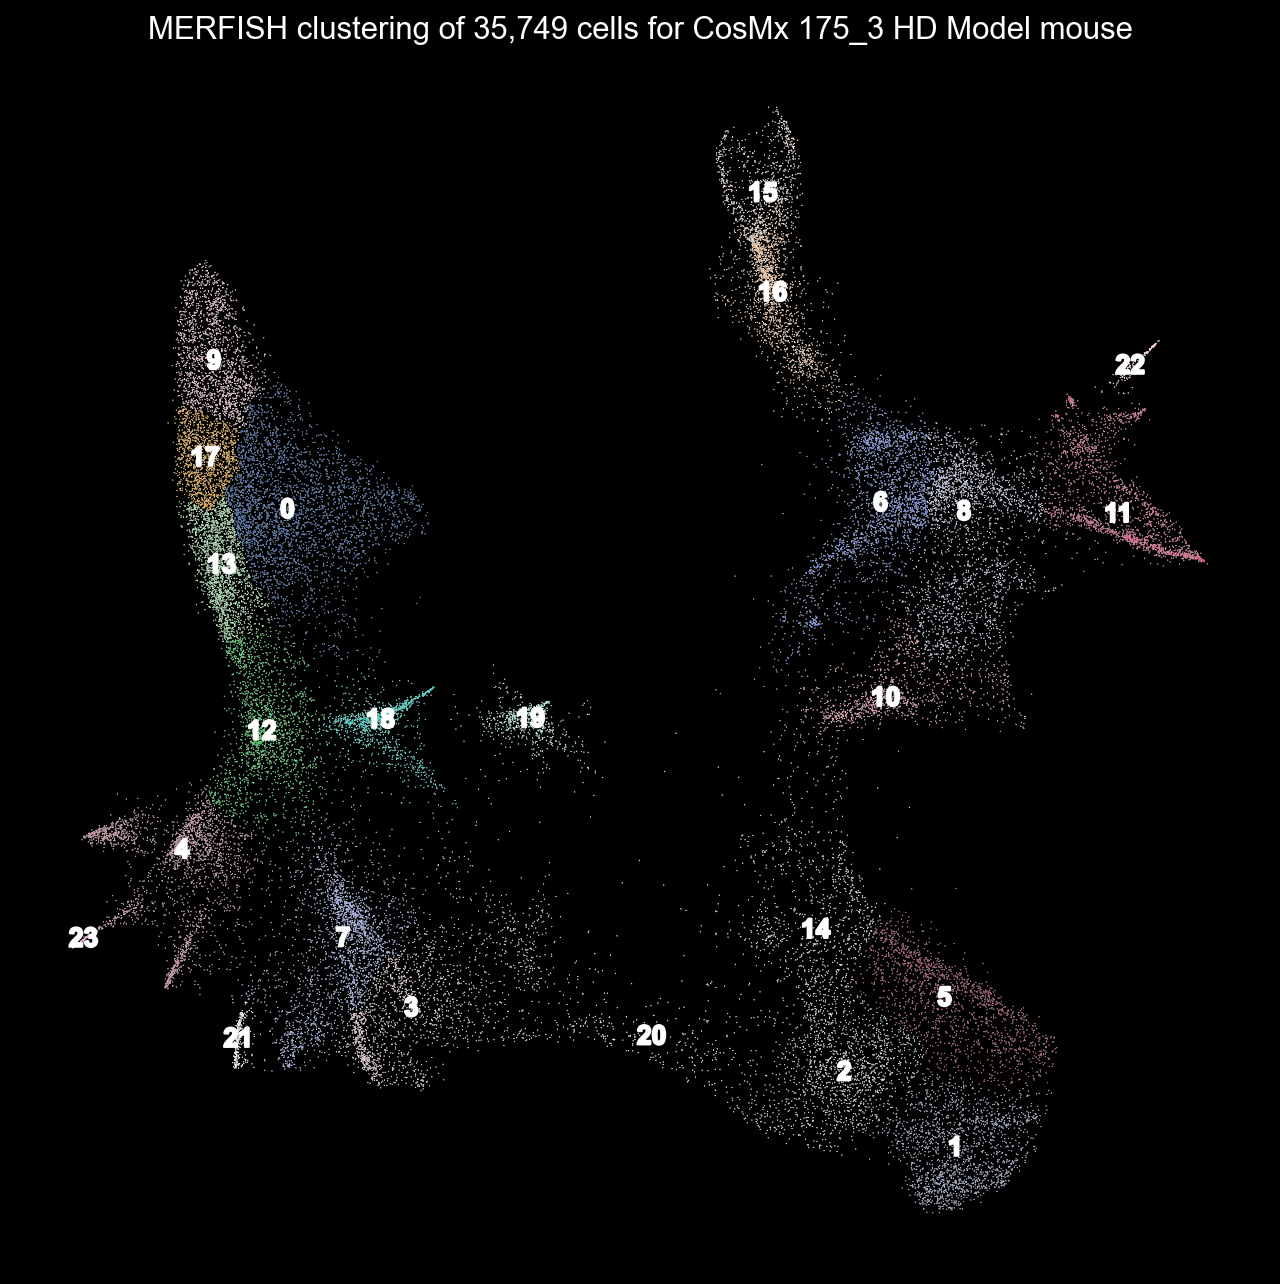

C:\Users\krist\AppData\Local\Programs\Python\Python311\Lib\site-packages\scanpy\plotting\_utils.py:432: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[value_to_plot + '_colors'] = colors_list
C:\Users\krist\AppData\Local\Programs\Python\Python311\Lib\site-packages\scanpy\plotting\_tools\scatterplots.py:371: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(
C:\Users\krist\AppData\Local\Programs\Python\Python311\Lib\site-packages\scanpy\plotting\_tools\scatterplots.py:381: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(
C:\Users\krist\AppData\Local\Programs\Python\Python311\Lib\site-packages\scanpy\plotting\_tools\scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


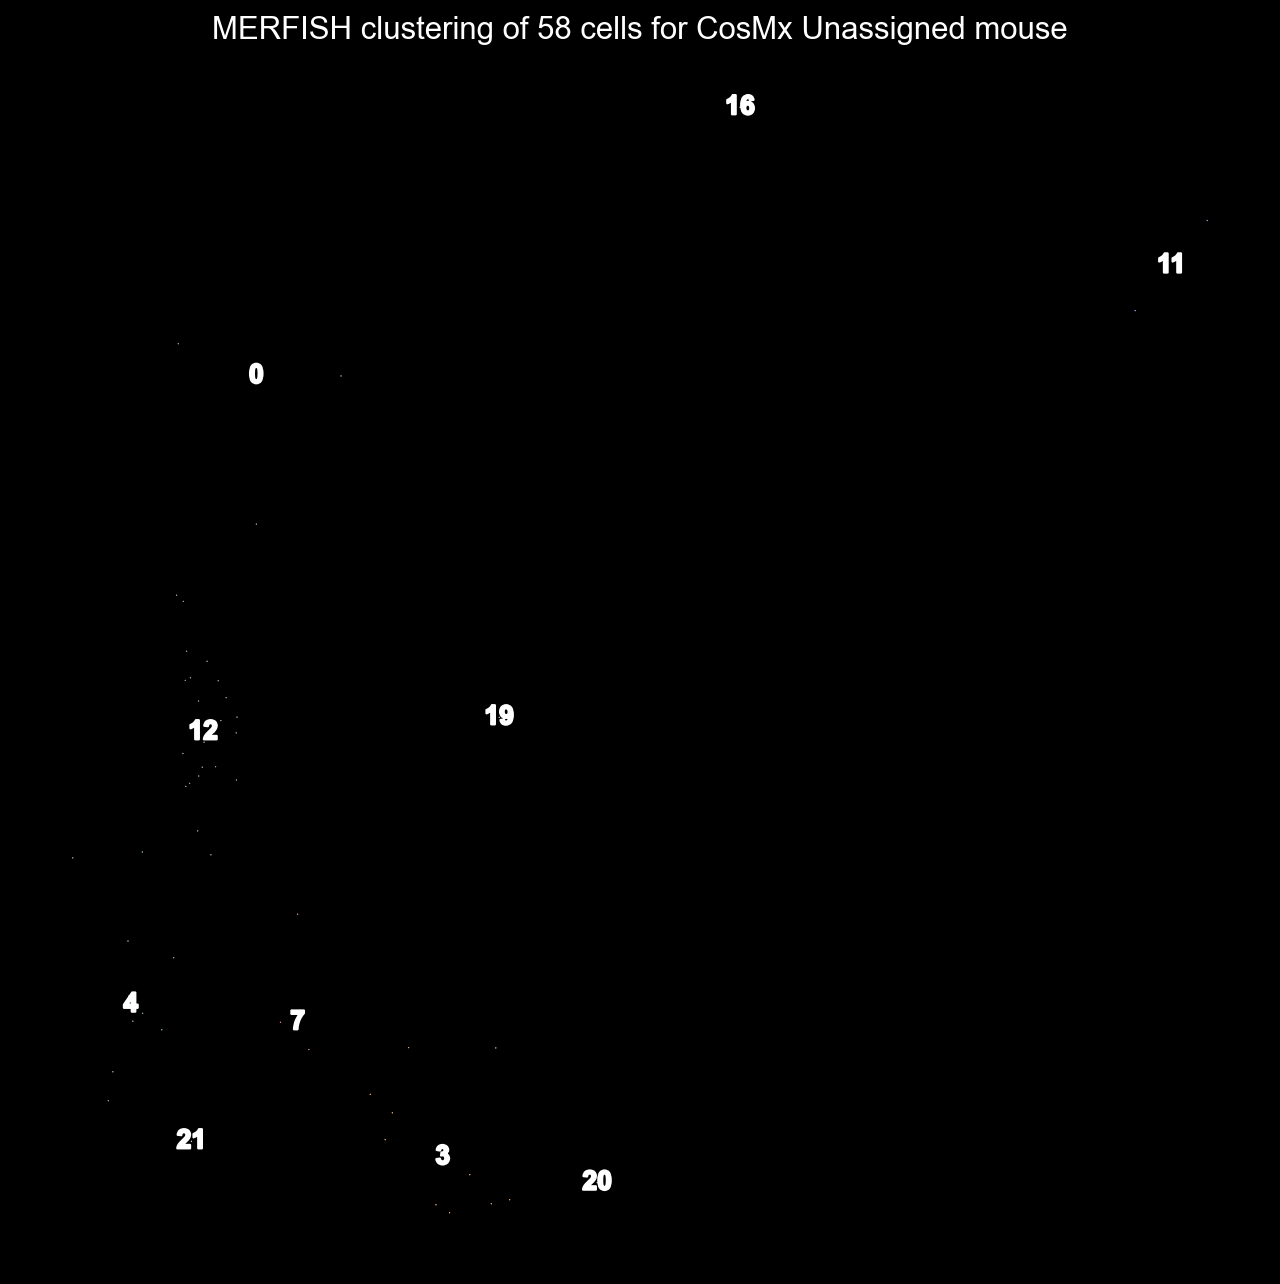

C:\Users\krist\AppData\Local\Programs\Python\Python311\Lib\site-packages\scanpy\plotting\_utils.py:432: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[value_to_plot + '_colors'] = colors_list
C:\Users\krist\AppData\Local\Programs\Python\Python311\Lib\site-packages\scanpy\plotting\_tools\scatterplots.py:371: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(
C:\Users\krist\AppData\Local\Programs\Python\Python311\Lib\site-packages\scanpy\plotting\_tools\scatterplots.py:381: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(
C:\Users\krist\AppData\Local\Programs\Python\Python311\Lib\site-packages\scanpy\plotting\_tools\scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


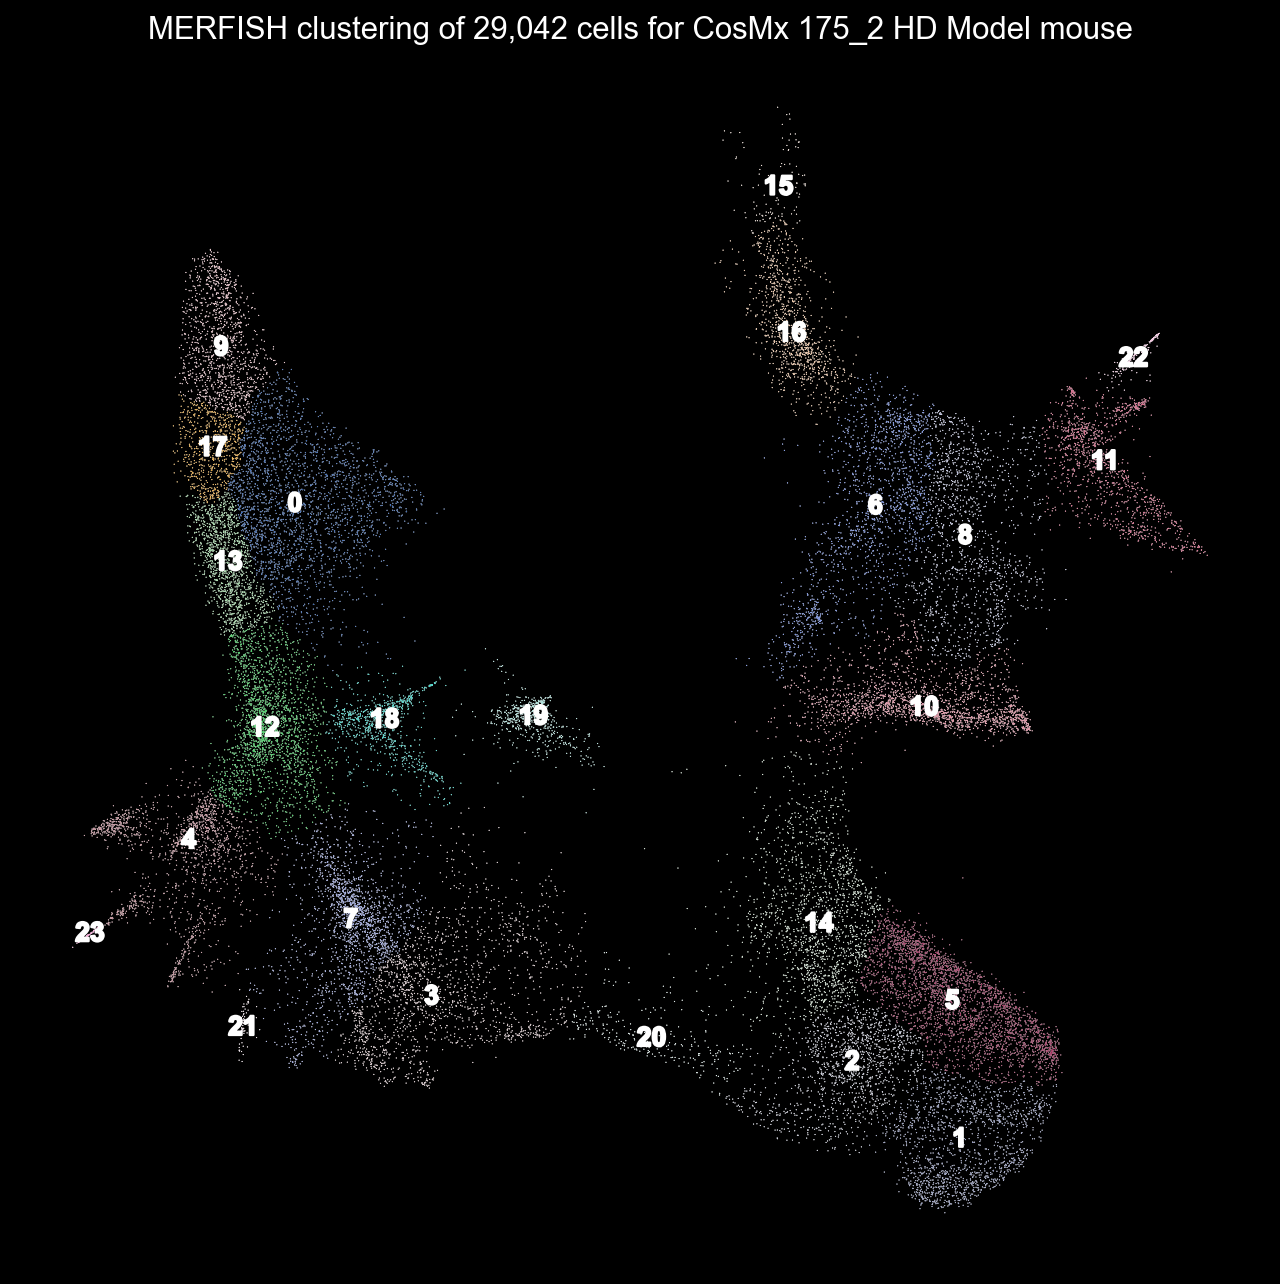

C:\Users\krist\AppData\Local\Programs\Python\Python311\Lib\site-packages\scanpy\plotting\_utils.py:432: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[value_to_plot + '_colors'] = colors_list
C:\Users\krist\AppData\Local\Programs\Python\Python311\Lib\site-packages\scanpy\plotting\_tools\scatterplots.py:371: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(
C:\Users\krist\AppData\Local\Programs\Python\Python311\Lib\site-packages\scanpy\plotting\_tools\scatterplots.py:381: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(
C:\Users\krist\AppData\Local\Programs\Python\Python311\Lib\site-packages\scanpy\plotting\_tools\scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


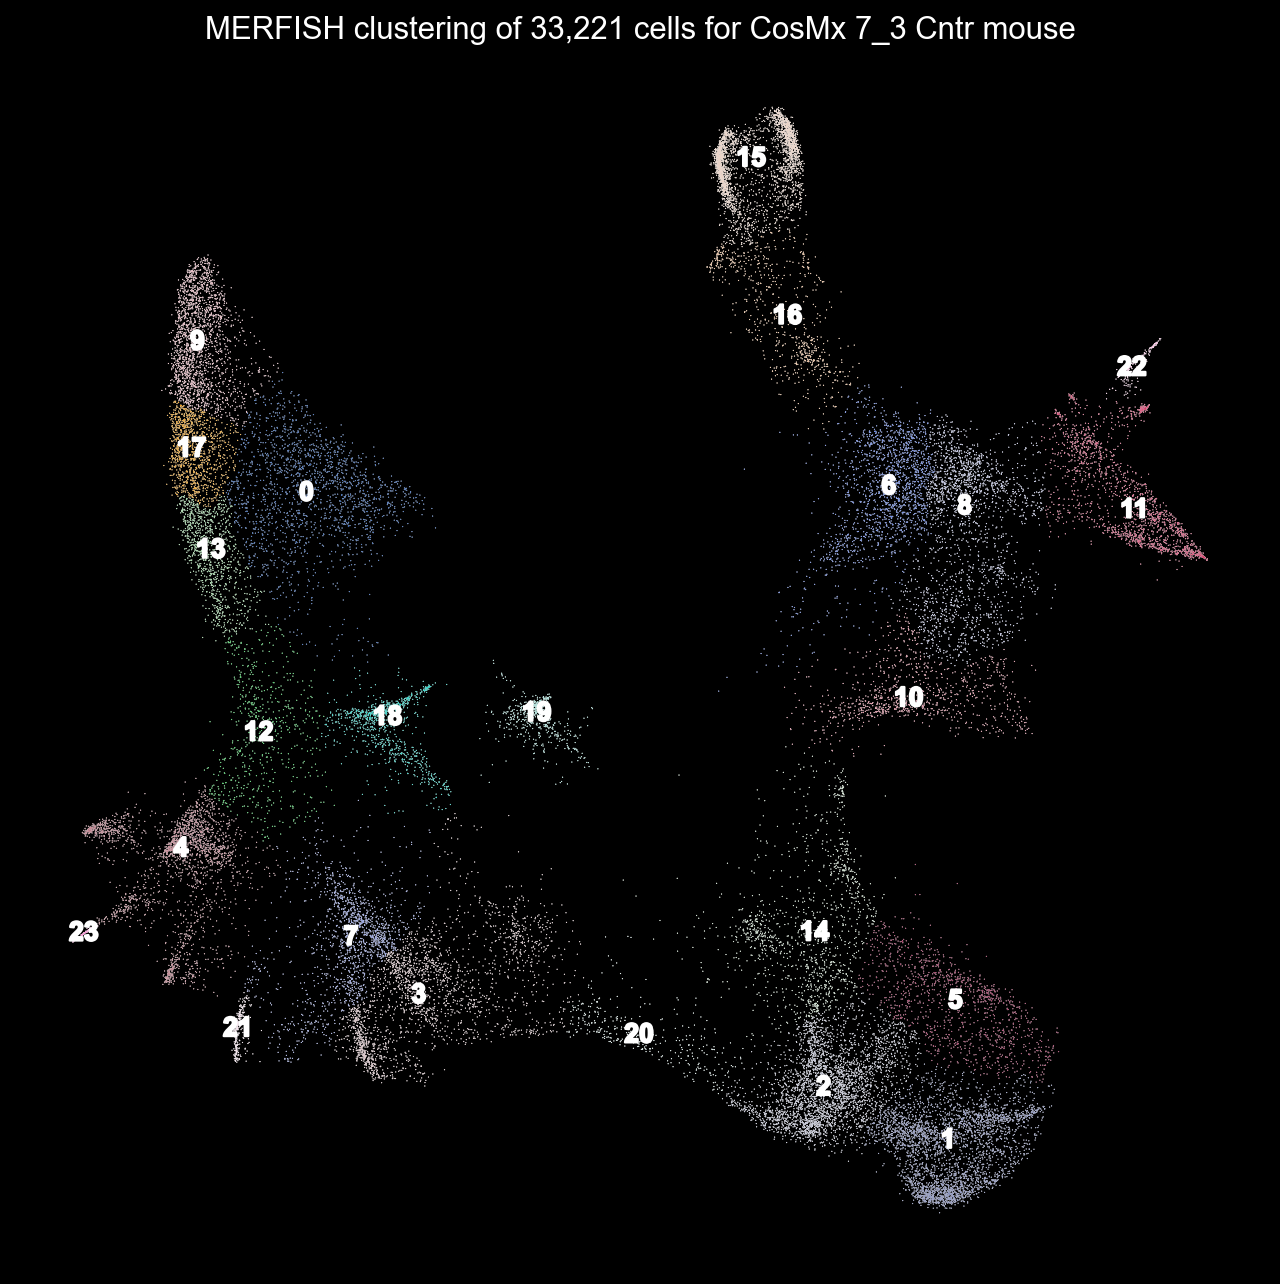

C:\Users\krist\AppData\Local\Programs\Python\Python311\Lib\site-packages\scanpy\plotting\_utils.py:432: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[value_to_plot + '_colors'] = colors_list
C:\Users\krist\AppData\Local\Programs\Python\Python311\Lib\site-packages\scanpy\plotting\_tools\scatterplots.py:371: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(
C:\Users\krist\AppData\Local\Programs\Python\Python311\Lib\site-packages\scanpy\plotting\_tools\scatterplots.py:381: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(
C:\Users\krist\AppData\Local\Programs\Python\Python311\Lib\site-packages\scanpy\plotting\_tools\scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


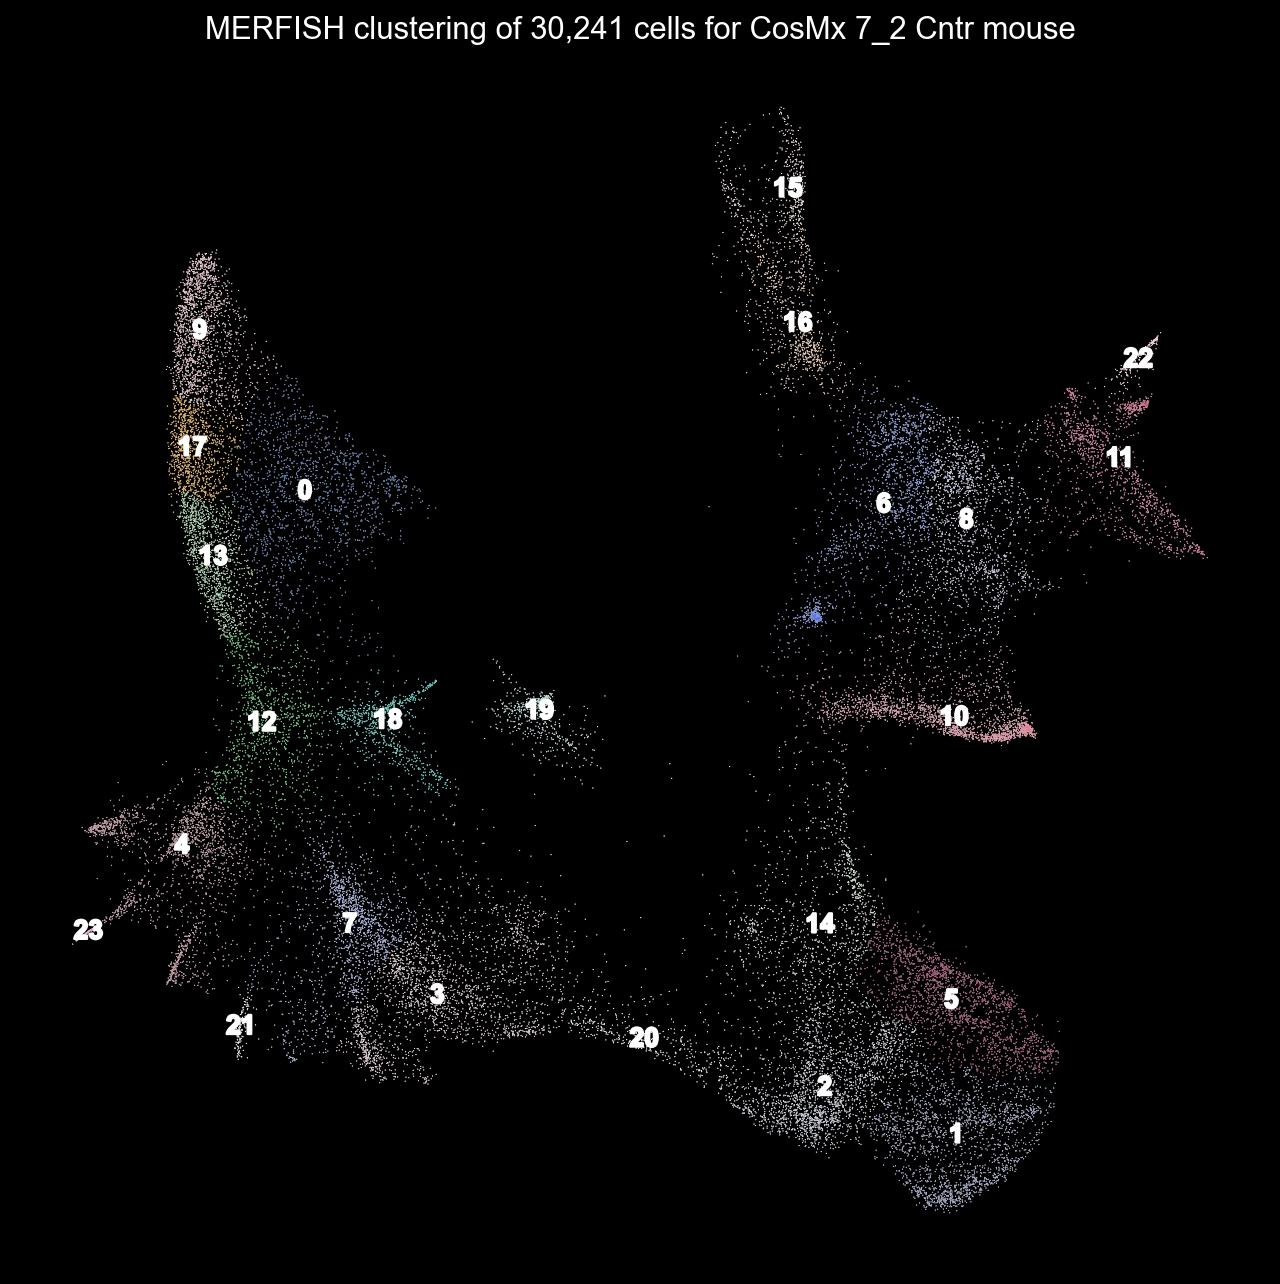

In [28]:
for sample in cosmx_sample_id_list:
    generate_umap(revised_cosmx_scdata[revised_cosmx_scdata.obs['identification'] == sample], sample_id = sample, color = 'leiden', color_map = 'coolwarm')